In [1]:
import MLMC_RSCAM as multi
import numpy as np
import types
import time
import inspect
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font',**{'serif':['cm']})
plt.style.use('seaborn-paper')
plt.rcParams.update({'axes.titlesize':36,'axes.labelsize': 30,'xtick.labelsize': 26,'ytick.labelsize': 26,
                    'legend.fontsize': 30,'legend.title_fontsize':30,'figure.titlesize': 40,'lines.linewidth' : 2})

In [2]:
#Define Milstein scheme for GBM SDE
def milstein_GBM(self,X,dt,t_,dW):
    return self.mu*X*dt+self.sig*X*dW+0.5*X*(self.sig**2)*(dW**2-dt)

#Define Milstein scheme for MJD SDE
def milstein_Merton(self,X,dt,t_,dW,dJ=0):
    dx_=(self.r-self.lam*self.J_bar)*X*dt+self.sig*X*dW+0.5*X*(self.sig**2)*(dW**2-dt)
    return dx_+(dx_+X)*dJ

#Define exercise boundary for American option
def exb(self,t):
    return np.maximum(self.K*(1-0.8*np.sqrt(self.T-t)),0)

In [3]:
print(multi.__doc__)


MLMC_RSCAM
Multilevel Monte Carlo Implementation for RSCAM Group 1
Luke Shaw, Olena Balan, Isabell Linde, Chantal Kool, Josh Mckeown
_______________________________________________________
Functions: Euro_payoff, Asian_payoff, Lookback_payoff, Digital_payoff, and anti_Euro_payoff payoffs.
(diffusion/JD)_path(_min/_avg) for diffusion and jump diffusion, coarse/fine final, avg, min asset prices.
(diffusion/JD)_asset_plot plotting functions for diffusion and jump diffusion asset prices.
Giles_plot plotting functions for mlmc variance/mean, samples per level/complexity and brownian_plot for discretised Brownian motion plots.
Use inspect.getmembers(mlmc_RSCAM,inspect.isroutine) to get full list.


Classes: Option, JumpDiffusion_Option, Diffusion_Option, Merton_Option, GBM_Option, MyOption.
With specific Euro_GBM/Euro_Merton, Lookback_GBM/Lookback_Merton, Asian_GBM/Asian_Merton, 
Digital_GBM/Digital_Merton implementations for Merton and GBM models. 
Use inspect.getmembers(mlmc_RSCAM,inspect

In [4]:
inspect.getmembers(multi,inspect.isclass)

[('Amer_GBM', MLMC_RSCAM.Amer_GBM),
 ('Asian_GBM', MLMC_RSCAM.Asian_GBM),
 ('Asian_Merton', MLMC_RSCAM.Asian_Merton),
 ('Diffusion_Option', MLMC_RSCAM.Diffusion_Option),
 ('Digital_GBM', MLMC_RSCAM.Digital_GBM),
 ('Digital_Merton', MLMC_RSCAM.Digital_Merton),
 ('Euro_GBM', MLMC_RSCAM.Euro_GBM),
 ('Euro_Merton', MLMC_RSCAM.Euro_Merton),
 ('GBM_Option', MLMC_RSCAM.GBM_Option),
 ('JumpDiffusion_Option', MLMC_RSCAM.JumpDiffusion_Option),
 ('Legend', matplotlib.legend.Legend),
 ('Lookback_GBM', MLMC_RSCAM.Lookback_GBM),
 ('Lookback_Merton', MLMC_RSCAM.Lookback_Merton),
 ('Merton_Option', MLMC_RSCAM.Merton_Option),
 ('MyOption', MLMC_RSCAM.MyOption),
 ('Option', MLMC_RSCAM.Option),
 ('WeakMethod', MLMC_RSCAM.WeakMethod)]

In [5]:
##List of methods (some not implemented - includes virtual methods)
opt=multi.Euro_Merton() #Instantiate a Euro call with default params
method_list = [func for func in dir(opt) if callable(getattr(opt, func)) and not func.startswith("__")]
method_list

['BS',
 'anti_path',
 'anti_payoff',
 'asset_plot',
 'jumpsize',
 'jumptime',
 'looper',
 'mlmc',
 'path',
 'payoff',
 'sde']

In [6]:
##Examine MLMC algorithm documentation
help(opt.mlmc)

Help on method mlmc in module MLMC_RSCAM:

mlmc(eps, M=2, anti=False, N0=1000, warm_start=True) method of MLMC_RSCAM.Euro_Merton instance
    Runs MLMC method for given option (e.g. European) which returns an array of sums at each level.
    ________________
    Example usage:
    Euro=Euro_GBM()
    sums,N=Euro.mlmc(eps=0.1)
    ________________
    
    Parameters:
        self(Option) : Option instance (with SDE params and order of weak convergence of method alpha_0)
        eps(float) : desired accuracy
        M(int) = 2 : coarseness factor
        anti(bool) = False : whether to use antithetic estimator
        N0(int) = 10**3 : default number of samples to use when initialising new level
        warm_start(bool) = True: whether to save calculated alpha as alpha_0 for future function calls
    
    Returns: sums=[np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,sum(Pf*Pc)],N
        sums(np.array) : sums of payoff diffs at each level and sum of payoffs at fine level, each c

In [7]:
##BS Comparison European Call with MJD##
opt=multi.Euro_Merton() #Instantiate a Euro call with default params
e=0.1 #Set desired accuracy

#Get runtime for MLMC algorithm using EM scheme with accuracy e
t=time.time()
#Set warm_start=False to not save estimated weak order of convergence alpha
sums,N=opt.mlmc(e,warm_start=False);
t_=time.time()
t1=t_-t
price_EM=sum(sums[0,:]/N)


#Set time-stepping to Milstein method
opt.sde=types.MethodType(milstein_Merton, opt)
#Get runtime for MLMC algorithm using Milstein scheme with accuracy 0.001
t=time.time()
sums,N=opt.mlmc(e,warm_start=False);
t_= time.time()
t2=t_-t
price_Mil=sum(sums[0,:]/N)
print(f'________________________________________________\nAccuracy = {e}')
print(f'EM MLMC Price = {round(price_EM,4)}. Runtime = {t1} s.')
print(f'Mil. MLMC Price = {round(price_Mil,4)}. Runtime = {t2} s.')
print(f'BS Price = {round(opt.BS(),4)}.') #Calculate and print out Black-Scholes price of option

Estimated alpha = 1.5716947552872225
Estimated alpha = 1.018444323196263
________________________________________________
Accuracy = 0.1
EM MLMC Price = 14.2499. Runtime = 3.480227470397949 s.
Mil. MLMC Price = 14.1519. Runtime = 4.178556680679321 s.
BS Price = 14.1936.


Estimated alpha = 1.0918592043722393
Estimated alpha = 1.2949742544519531
Estimated alpha = 1.3865903151030559
Estimated alpha = 1.5014451918624092
Estimated alpha = 1.9088419844130895
Estimated alpha = 1.6274022767049119
Estimated alpha = 1.9800365437607466
Estimated alpha = 1.5007148664166094
Estimated alpha = 1.5496625507713346
Estimated alpha = 1.4654702605976981


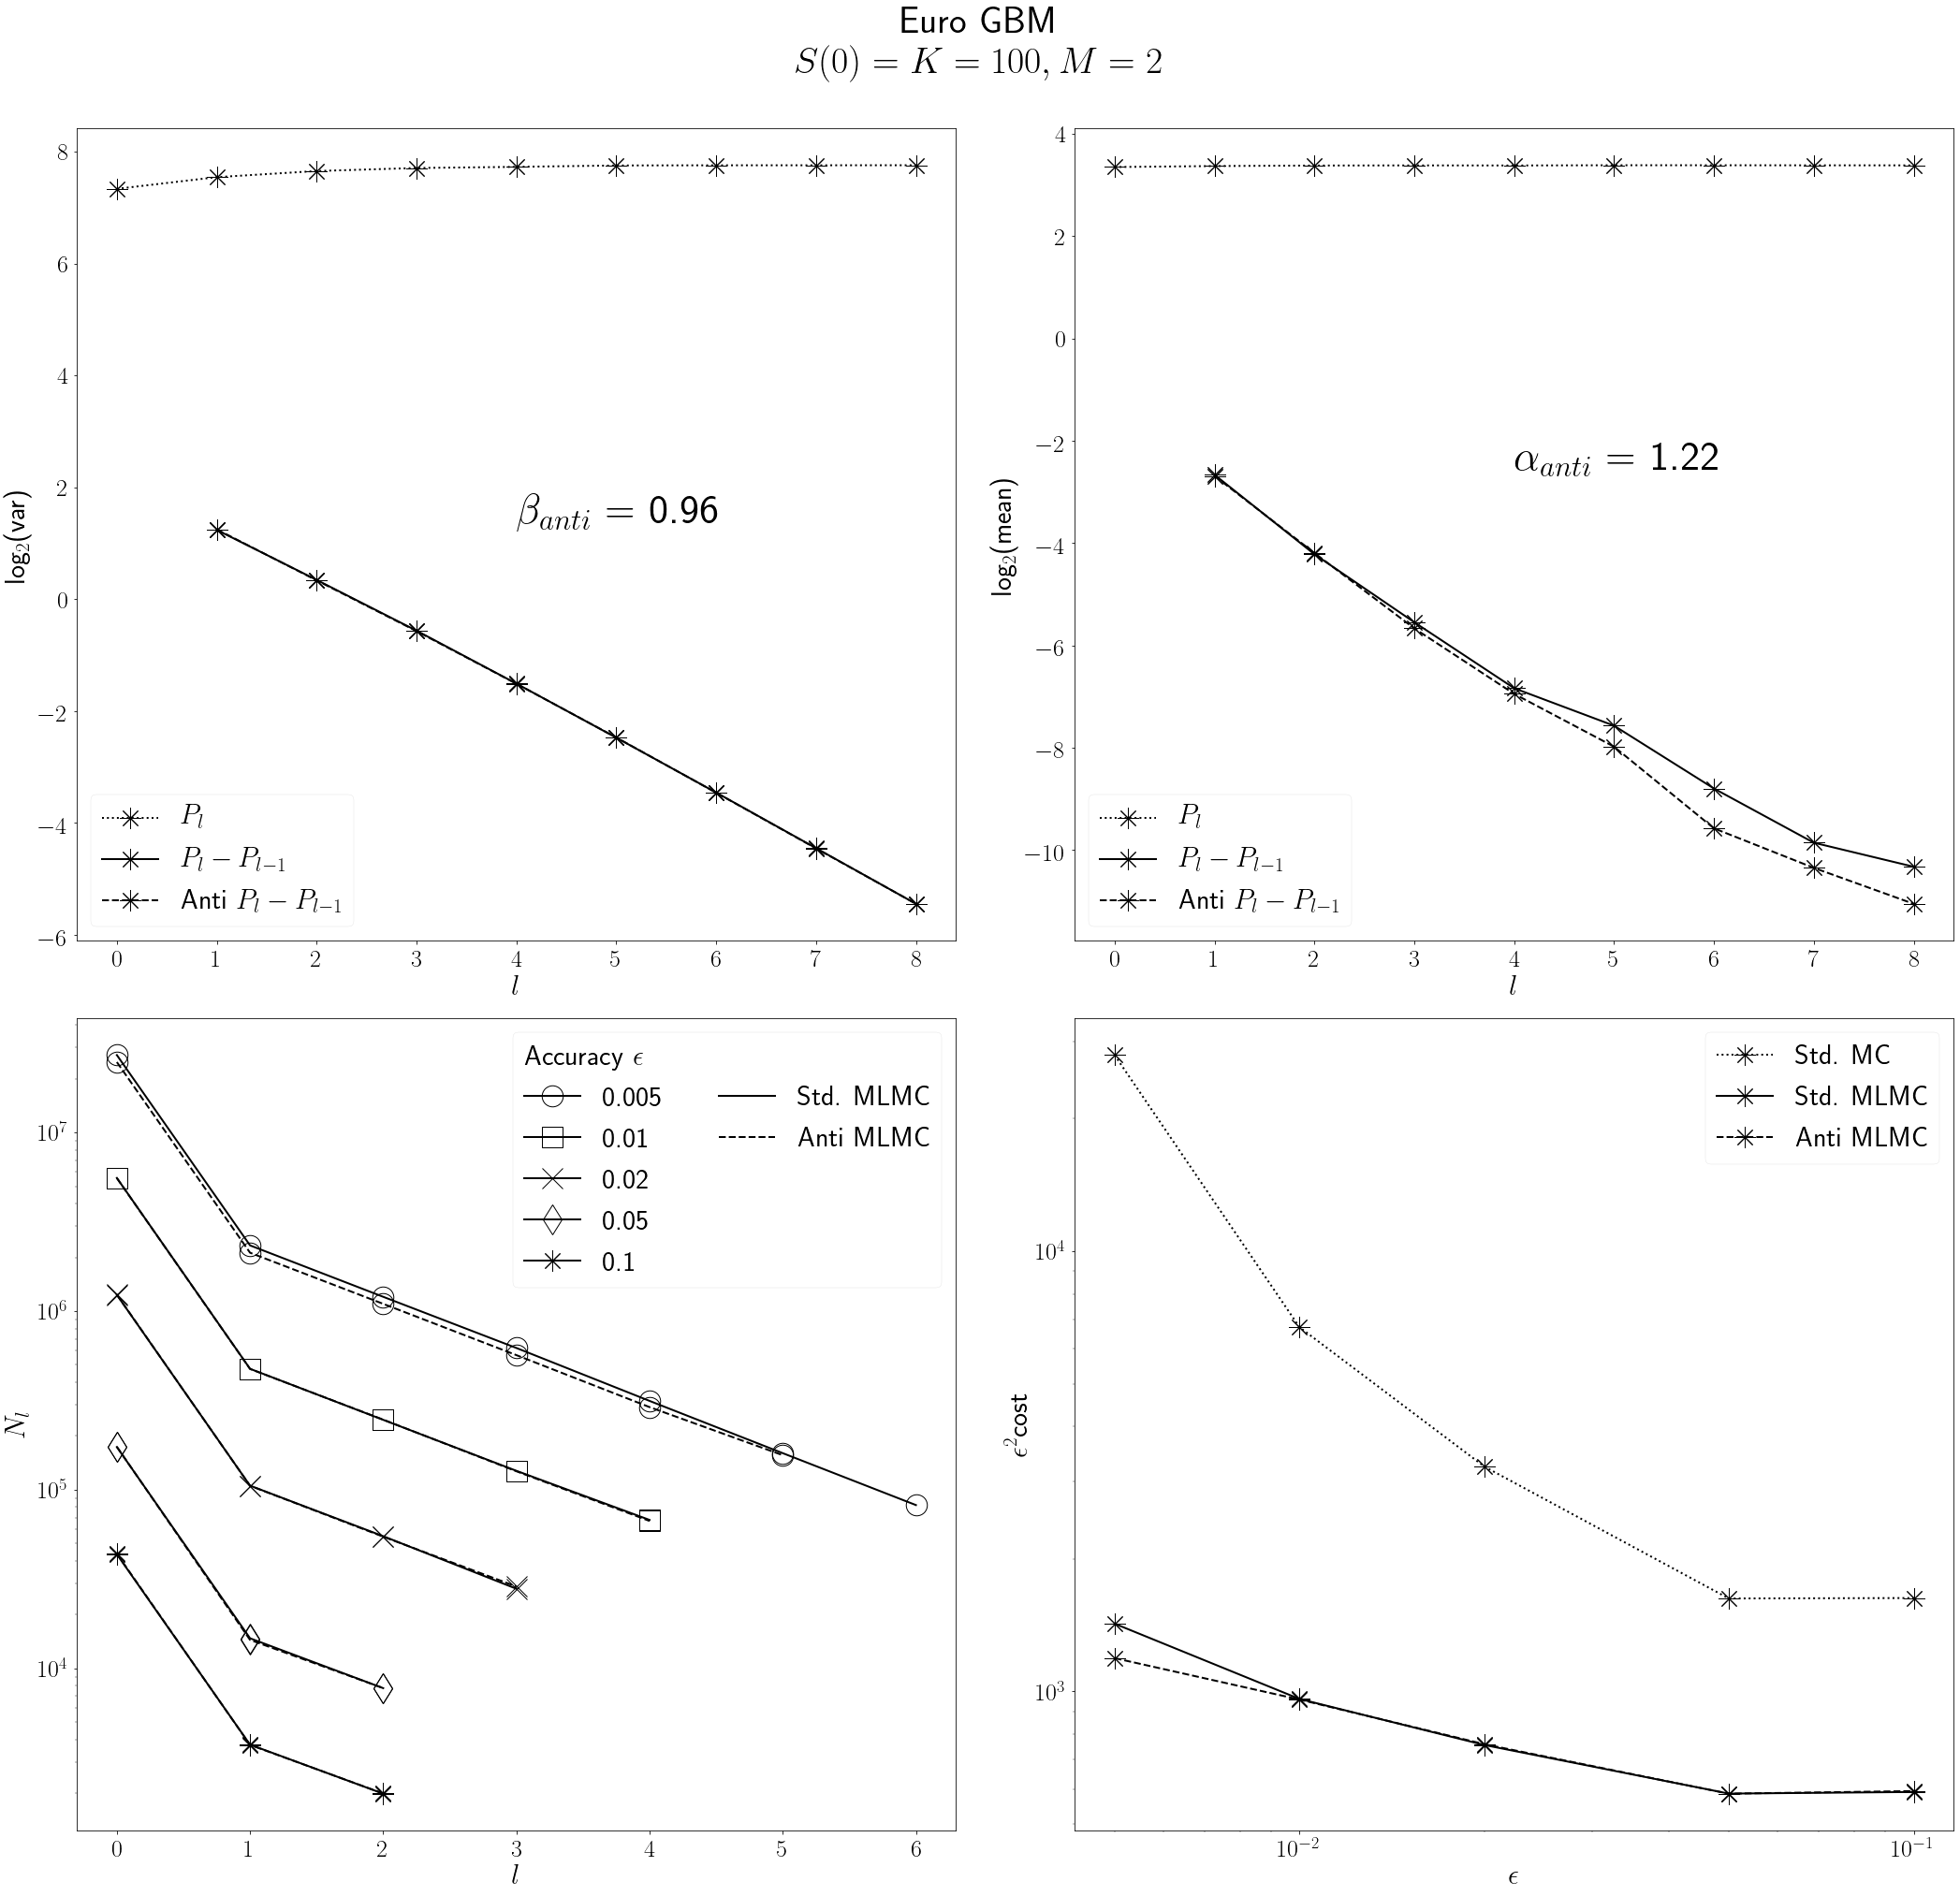

In [8]:
##Giles-style plot for European GBM
eps=[0.005,0.01,0.02,0.05,0.1]
fig,ax=plt.subplots(2,2,figsize=(30,30))
opt=multi.Euro_GBM() #instantiate Euro call with GBM
markers=['o','s','x','d',(8,2,0)]
#Plot
multi.Giles_plot(opt,markers=markers,eps=eps,label='Euro GBM',fig=fig,anti=True)


Estimated alpha = 1.1753585630459848
Estimated alpha = 1.3091545620470344
Estimated alpha = 1.1374434960084165
Estimated alpha = 1.2678253569181976
Estimated alpha = 0.971279114170407


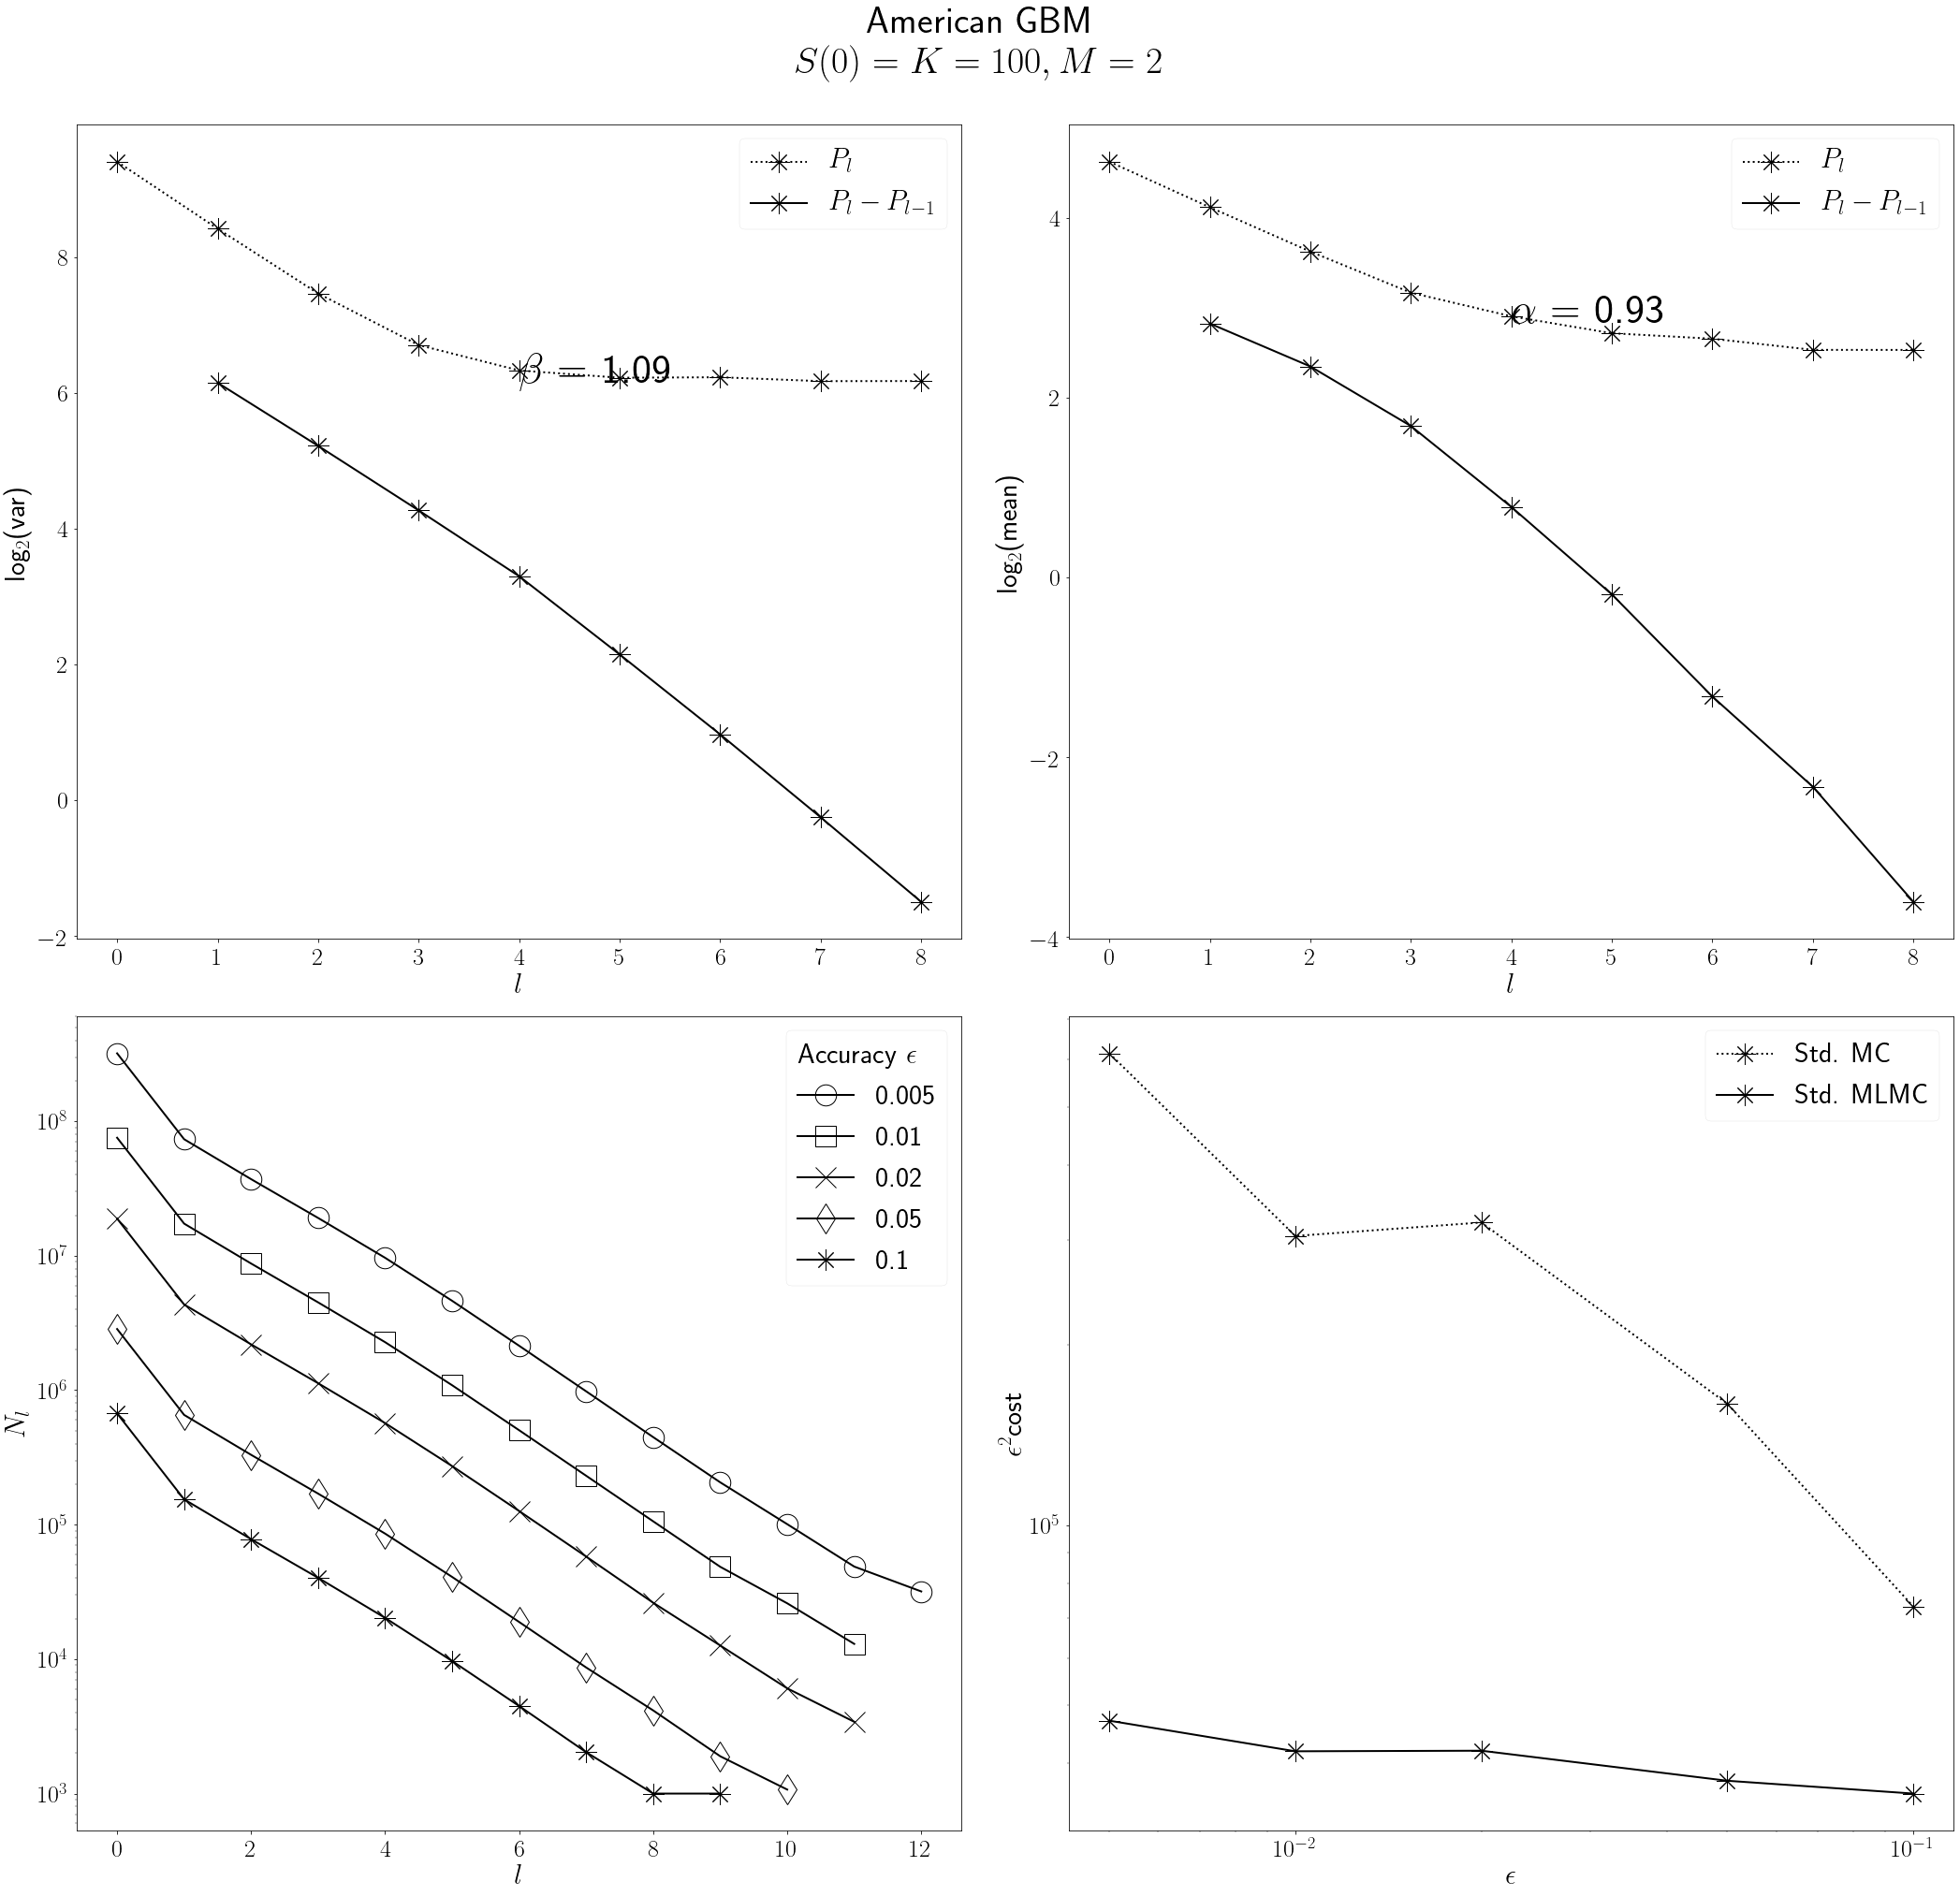

In [9]:
##Giles-style plot for American GBM
opt=multi.Amer_GBM(exerciseBoundary=exb) #instantiate Euro call with GBM
fig,ax=plt.subplots(2,2,figsize=(30,30))
multi.Giles_plot(opt,markers=markers,eps=eps,label='American GBM',fig=fig,Nsamples=10**4)


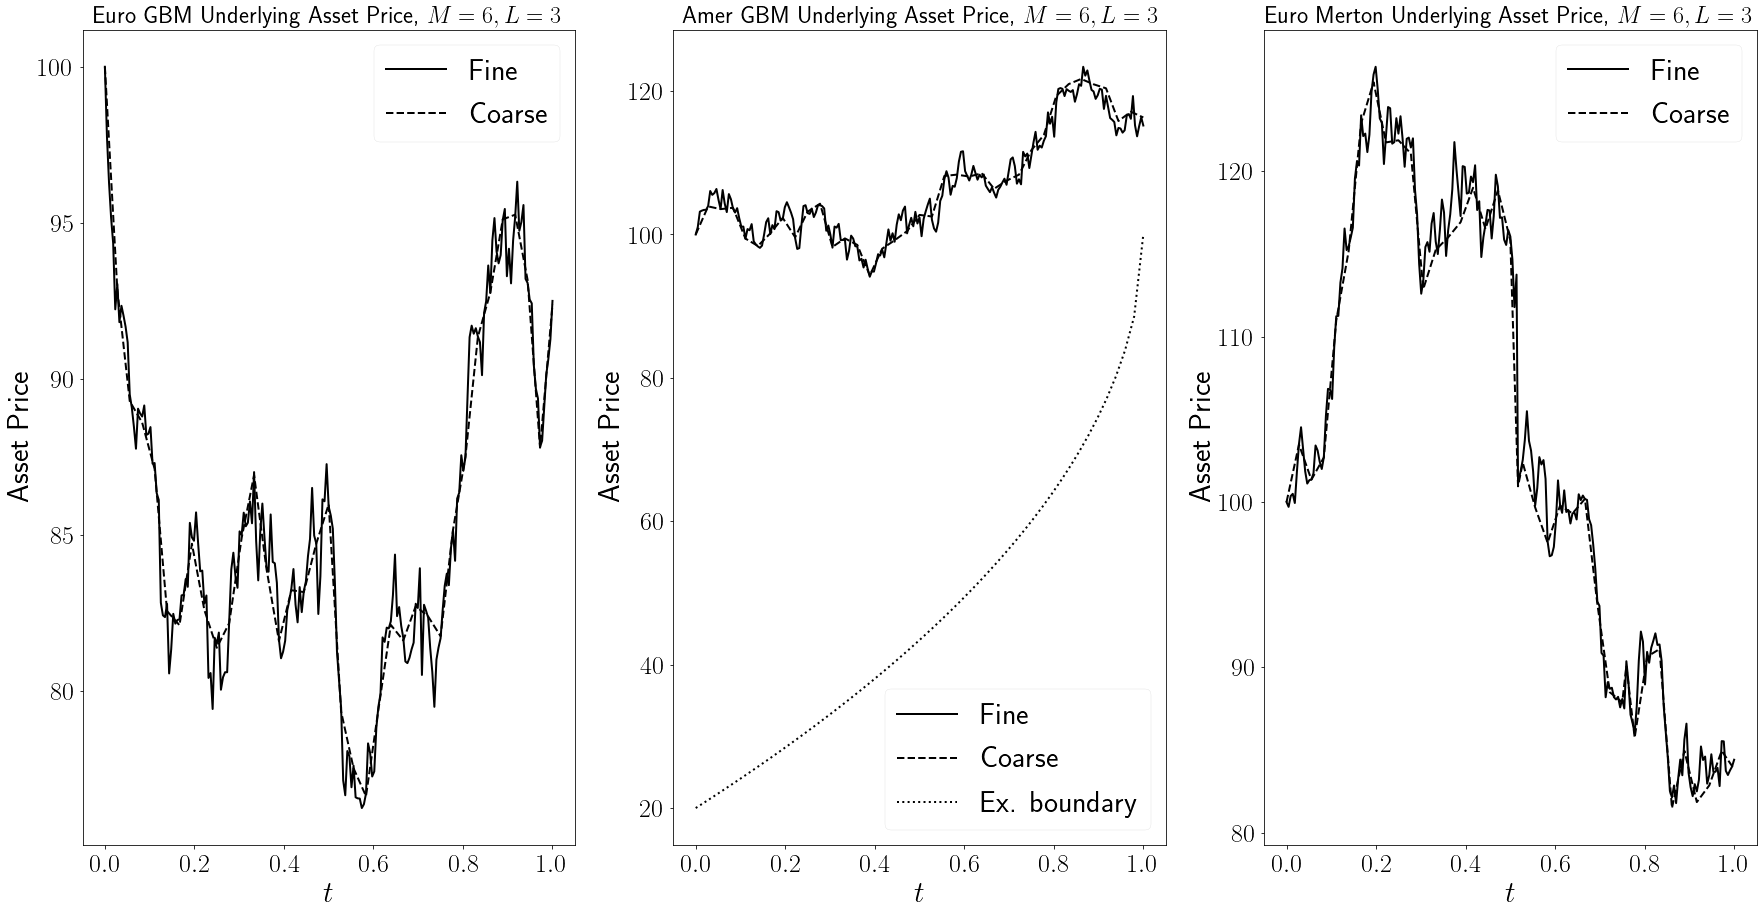

In [8]:
##Asset plots for MJD and GBM
GBM=multi.Euro_GBM()
Am=multi.Amer_GBM(exb)
MJD=multi.Euro_Merton(lam=3) #MJD with three jumps per unit time
plt.rcParams.update({'axes.titlesize':24})
fig,ax=plt.subplots(1,3,figsize=(30,15))
plt.sca(ax[0])
GBM.asset_plot(L=3,M=6)
plt.sca(ax[1])
Am.asset_plot(L=3,M=6)
plt.sca(ax[2])
MJD.asset_plot(L=3,M=6)
plt.savefig('Nice_Images/AssetPlots',format='pdf')

In [ ]:
##Giles-Style plots for all other options
markers=['o','s','x','d',(8,2,0)]
for label,func in {'European':mlmc.Euro_GBM,'Asian':mlmc.Asian_GBM,
                   'Lookback':mlmc.Lookback_GBM,'Digital':mlmc.Digital_GBM}.items():
    option=func()
    fig,ax=plt.subplots(2,2,figsize=(30,30))
    multi.Giles_plot(option,[0.005,0.01,0.02,0.05,0.1],markers=markers,label=label+' GBM',fig=fig)

for label,func in {'European':mlmc.Euro_Merton,'Asian':mlmc.Asian_Merton,
                   'Lookback':mlmc.Lookback_Merton,'Digital':mlmc.Digital_Merton}.items():
    option=func()
    fig,ax=plt.subplots(2,2,figsize=(30,30))
    multi.Giles_plot(option,[0.005,0.01,0.02,0.05,0.1],markers=markers,label=label+' MJD',fig=fig)


In [ ]:
#MLMC/BS Comparison Plots
fig,ax=plt.subplots(2,2,figsize=(30,16),sharex=True)
eps=np.arange(0.01,0.11,0.01)
for label,func in {'European':mlmc.Euro_GBM,'Asian':mlmc.Asian_GBM,
                   'Lookback':mlmc.Lookback_GBM,'Digital':mlmc.Digital_GBM}.items():
    option=func()
    p=[]
    if label=='European':
        axis=ax[0,0]
        axis.set_ylabel('Call Option Price')
    elif label=='Asian':
        axis=ax[0,1]
    elif label=='Lookback':
        axis=ax[1,0]
        axis.set_ylabel('Call Option Price')
        axis.set_xlabel('$\epsilon$')
    else:
        axis=ax[1,1]
        axis.set_xlabel('$\epsilon$')
    for e in eps:
        sums,N=option.mlmc(e,M=2)
        p+=[np.sum(sums[0,:]/N)]
    axis.plot(eps,p,'k--',label='MLMC')
    axis.fill_between(eps, p+eps, p-eps, alpha=.5,label='$\pm\epsilon$')
    axis.plot(eps,option.BS()*np.ones(len(eps)),'k-',label='Black-Scholes')
    axis.set_title(label)
lgd=plt.legend(loc="upper left", bbox_to_anchor=(1,1.1))
text=fig.suptitle(f'GBM Call Options, $T={option.T}, S(0)={option.X0}, K={option.K}, r={option.r*100}\%, \sigma={option.sig}$',fontsize=36);
fig.tight_layout(rect=[0, 0.03, 1, 0.94],w_pad=2,h_pad=2)
plt.savefig('Nice_Images/BSComparison_GBM',bbox_extra_artists=(lgd,text), bbox_inches='tight')

In [ ]:
##Testing optimal control variate factors for MJD Options
plt.rcParams['legend.title_fontsize'] = 24
plt.figure(figsize=(16,12))
M=2
e=0.05
markers=['o','s','x','d']
i=0
plt.title(f'Merton JD SDE, $\lambda^*$\n$M={M}, \epsilon={e}$');
plt.xlabel('$l$')
plt.ylabel('$\lambda^{*}$')

for label,func in {'European':mlmc.Euro_Merton,'Asian':mlmc.Asian_Merton,
                   'Lookback':mlmc.Lookback_Merton,'Digital':mlmc.Digital_Merton}.items():
    option=func()
    sums,N=option.mlmc(e,M=M)
    Vg=sums[5,:]/N-(sums[4,:]/N)**2
    lam=((sums[6,:]/N)-(sums[2,:]/N)*(sums[4,:]/N))/Vg
    plt.plot(range(len(N)),lam,'k-',marker=markers[i],label=label,
               markersize=20,markerfacecolor="None",markeredgecolor='k', markeredgewidth=1)
    i+=1
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(title='Call Option',fontsize=14,labelspacing=1)